# Strava: Guide to data extraction and analysis

<img src='https://i.imgur.com/jneRMpU.jpg' height="500"> 

A picture of the Strava Mobile Application


Strava is often regarded as the “social network for athletes.” It lets you track your running and riding with GPS, join Challenges, share photos from your activities, and follow friends. <br>

Strava follows a fremium model offering a digital service accessible through its mobile applications (iOS and Android). Users also have an option to upgrade and unlock more advanced features like Custom Goals, Training Plans, Race Analysis, etc for a monthly fee of $5-8. <br>

We've been using the strava application for the past few weeks and we will show you how to extract its data, visualize your runs and compute correlations between multiple metrics of the data. The Strava API allows the users to extract all sorts of data on athletes, segments, routes, clubs, and gear. However, for this notebook we will be focusing on metrics of the participant's activities like dates, speed, elevation, duration, etc.



We will be able to extract the following parameters:

Parameter Name  | Sampling Frequency 
-------------------|-----------------
<b>Moving Time</b> |  Per Activity 
<b>Elapsed Time</b> |  Per Activity 
<b>Average Speed</b> |  Per Activity 
<b>Maximum Speed</b> |  Per Activity 
<b>Average Cadence</b> |  Per Activity
<b>Maximum Cadence</b> |  Per Activity
<b>Average Watts</b> |  Per Activity
<b>Maximum Watts</b> |  Per Activity
<b>Average Heart Rate</b> |  Per Activity
<b>Maximum Heartrate</b> |  Per Activity
<b>Distance</b>      |  Records every change in user's position
<b>Polyline Summary</b> |  Records every change in user's position
<b>Total Elevation Gain</b> |  Sampling Frequency depends upon user's fitness tracker
<b>Heart Rate</b>  | Sampling Frequency depends upon user's fitness tracker

** All of these are individual paramaters that can be directly extracted using wearipedia

In this guide, we sequentially cover the following **five** topics to extract data from Cronometer servers:

1. **Set up**<br>
2. **Authentication/Authorization**<br>
   - Requires only client_id, client_secret and refresh_token.<br>
3. **Data extraction**<br>
  - We get data via wearipedia in a couple lines of code<br>
4. **Data Exporting**
    - We export all of this data to file formats compatible by R, Excel, and MatLab.
5. **Adherence**
    - We simulate non-adherence by dynamically removing datapoints from our simulated data.
6. **Visualization**
    - We create a simple plot to visualize our data.
7. **Advanced visualization**
    - 7.1 Visualizing participant's Overall Activity!<br>
    - 7.2 Visualizing participant's Weekly Summary!<br>
    - 7.3 Visualizing Participant's Runs!<br>
8. **Statistical Data Analysis** <br>
  - 8.1  Analyzing correlation between Participant's data! <br>
9. **Outlier Detection and Data Cleaning** <br>
  - 9.1 Highlighting Outliers!

Disclaimer: this notebook is purely for educational purposes. All of the data currently stored in this notebook is purely *synthetic*, meaning randomly generated according to rules we created. Despite this, the end-to-end data extraction pipeline has been tested on our own data, meaning that if you enter your own email and password on your own Colab instance, you can visualize your own *real* data. That being said, we were unable to thoroughly test the timezone functionality, though, since we only have one account, so beware.

# 1. Setup

## Participant Setup

Dear Participant,

Once you download the strava app, please set it up by following these resources:
- Written guide: https://www.runnersworld.com/beginner/g25619156/what-is-strava/
- Video guide: https://www.youtube.com/watch?v=LHtCxdrZFJ8&ab_channel=RunWithJ

Make sure that your phone is logged to the strava app using the Strava login credentials (email and password) given to you by the data receiver.

Best,

Wearipedia

## Data Receiver Setup

Please follow the below steps:

1. Create an email address for the participant, for example `foo@email.com`.
2. Create a Strava account with the email `foo@email.com` and some random password.
3. Keep `foo@email.com` and password stored somewhere safe.
4. Distribute the device to the participant and instruct them to follow the participant setup letter above.
5. Next, go to https://developers.strava.com/
6. Click on "Create and Manage your App"
<img src='https://i.imgur.com/nBdQDR6.png' width="850" height="500">
7. Strava will prompt you to login. Make sure to login with the account that participants' credentials
8. Fill out your details:<br>
   Here's an example with some dummy information! <br>
   <img src='https://i.imgur.com/O9jRXQQ.png' width="450" height="400">
9. Next, Strava will ask you to upload a app icon. I personally uploaded the Strava logo in the option. <br>
    <img src='https://i.imgur.com/wQHGyL2.png' width="600" height="400"> <br> 
   Copy and crop the Image to your preference and hit save! <br>
    <img src='https://i.imgur.com/kKodoZm.png' width="600" height="400">
10. You're done! <br>
    <img src='https://i.imgur.com/Svm3FV8.png' width="600" height="400"> <br>
    Copy and paste your your client ID, Client Token and Refresh token in the box below and give it to the researcher.
11. Install the `wearipedia` Python package to easily extract data from this device via the Strava API.


In [1]:
!pip install wearipedia
!pip install openpyxl

In [2]:
import wearipedia
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import json
import pandas as pd
import datetime

# 2. Authentication and Authorization

To obtain access to data, authorization is required. All you'll need to do here is just put in your client id, client secret token and refresh token for your Strava account. We'll use this to extract the data in the sections below.

In [3]:
#@title Enter Strava API credentials
client_id = "83434" #@param {type:"string"}
client_secret = "" #@param {type:"string"}
refresh_token = "" #@param {type:"string"}

# 3. Data Extraction

Data can be extracted via [wearipedia](https://github.com/Stanford-Health/wearipedia/), our open-source Python package that unifies dozens of complex wearable device APIs into one simple, common interface.

First, we'll set a date range and then extract all of the data within that date range. You can select whether you would like synthetic data or not with the checkbox.

In [4]:
#@title Enter start and end dates (in the format yyyy-mm-dd)

#set start and end dates - this will give you all the data from 2000-01-01 (January 1st, 2000) to 2100-02-03 (February 3rd, 2100), for example
start_date='2022-03-01' #@param {type:"string"}
end_date='2022-06-17' #@param {type:"string"}
synthetic = True #@param {type:"boolean"}

In [5]:
device = wearipedia.get_device("strava/strava")

if not synthetic:
    device.authenticate({
    'client_id':client_id,
    'client_secret':client_secret,
    'refresh_token':refresh_token
    })

params = {"start_date": start_date, "end_date": end_date}

distance = device.get_data("distance", params=params)
moving_time = device.get_data("moving_time", params=params)
elapsed_time = device.get_data("elapsed_time", params=params)
total_elevation_gain = device.get_data("total_elevation_gain", params=params)
average_speed = device.get_data("average_speed", params=params)
max_speed = device.get_data("max_speed", params=params)
average_heartrate = device.get_data("average_heartrate", params=params)
max_heartrate = device.get_data("max_heartrate", params=params)
map_summary_polyline = device.get_data("map_summary_polyline", params=params)
elev_high = device.get_data("elev_high", params=params)
elev_low = device.get_data("elev_low", params=params)
average_cadence = device.get_data("average_cadence", params=params)
average_watts = device.get_data("average_watts", params=params)
kilojoules = device.get_data("kilojoules", params=params)


# 4. Data Exporting

In this section, we export all of this data to formats compatible with popular scientific computing software (R, Excel, Google Sheets, Matlab). Specifically, we will first export to JSON, which can be read by R and Matlab. Then, we will export to CSV, which can be consumed by Excel, Google Sheets, and every other popular programming language.

## Exporting to JSON (R, Matlab, etc.)

Exporting to JSON is fairly simple. We export each datatype separately and also export a complete version that includes all simultaneously.

In [6]:
def datacleanup(data):
    for d in data:
        d['start_date'] = str(d['start_date'])
    return data

json.dump(datacleanup(distance), open("distance.json", "w"))
json.dump(datacleanup(moving_time), open("moving_time.json", "w"))
json.dump(datacleanup(elapsed_time), open("elapsed_time.json", "w"))
json.dump(datacleanup(total_elevation_gain), open("total_elevation_gain.json", "w"))
json.dump(datacleanup(average_speed), open("average_speed.json", "w"))
json.dump(datacleanup(max_speed), open("max_speed.json", "w"))
json.dump(datacleanup(average_heartrate), open("average_heartrate.json", "w"))
json.dump(datacleanup(max_heartrate), open("max_heartrate.json", "w"))
json.dump(datacleanup(map_summary_polyline), open("map_summary_polyline.json", "w"))
json.dump(datacleanup(elev_high), open("elev_high.json", "w"))
json.dump(datacleanup(elev_low), open("elev_low.json", "w"))
json.dump(datacleanup(average_cadence), open("average_cadence.json", "w"))
json.dump(datacleanup(average_watts), open("average_watts.json", "w"))
json.dump(datacleanup(kilojoules), open("kilojoules.json", "w"))


complete = {
    "distance": distance,
    'moving_time':moving_time,
    'elapsed_time':elapsed_time,
    'total_elevation_gain':total_elevation_gain,
    'average_speed':average_speed,
    'max_speed':max_speed,
    'average_heartrate':average_heartrate,
    'max_heartrate':max_heartrate,
    'map_summary_polyline':map_summary_polyline,
    'elev_high':elev_high,
    'elev_low':elev_low,
    'average_cadence':average_cadence,
    'average_watts':average_watts,
    'kilojoules':kilojoules
}

json.dump(complete, open("complete.json", "w"))

Feel free to open the file viewer (see left pane) to look at the outputs!

## Exporting to CSV and XLSX (Excel, Google Sheets, R, Matlab, etc.)

Exporting to CSV/XLSX requires a bit more processing, since they enforce a pretty restrictive schema.

We will thus export steps, heart rates, and breath rates all as separate files.

In [7]:
distance_df = pd.DataFrame.from_dict(complete['distance'])
distance_df.to_csv('distance.csv')
distance_df.to_excel('distance.xlsx')

moving_time_df = pd.DataFrame.from_dict(complete['moving_time'])
moving_time_df.to_csv('moving_time.csv')
moving_time_df.to_excel('moving_time.xlsx')

elapsed_time_df = pd.DataFrame.from_dict(complete['elapsed_time'])
elapsed_time_df.to_csv('elapsed_time.csv')
elapsed_time_df.to_excel('elapsed_time.xlsx')

total_elevation_gain_df = pd.DataFrame.from_dict(complete['total_elevation_gain'])
total_elevation_gain_df.to_csv('total_elevation_gain.csv')
total_elevation_gain_df.to_excel('total_elevation_gain.xlsx')

average_speed_df = pd.DataFrame.from_dict(complete['average_speed'])
average_speed_df.to_csv('average_speed.csv')
average_speed_df.to_excel('average_speed.xlsx')

max_speed_df = pd.DataFrame.from_dict(complete['max_speed'])
max_speed_df.to_csv('max_speed.csv')
max_speed_df.to_excel('max_speed.xlsx')

average_heartrate_df = pd.DataFrame.from_dict(complete['average_heartrate'])
average_heartrate_df.to_csv('average_heartrate.csv')
average_heartrate_df.to_excel('average_heartrate.xlsx')

max_heartrate_df = pd.DataFrame.from_dict(complete['max_heartrate'])
max_heartrate_df.to_csv('max_heartrate.csv')
max_heartrate_df.to_excel('max_heartrate.xlsx')

map_summary_polyline_df = pd.DataFrame.from_dict(complete['map_summary_polyline'])
map_summary_polyline_df.to_csv('map_summary_polyline.csv')
map_summary_polyline_df.to_excel('map_summary_polyline.xlsx')

elev_high_df = pd.DataFrame.from_dict(complete['elev_high'])
elev_high_df.to_csv('elev_high.csv')
elev_high_df.to_excel('elev_high.xlsx')

elev_low_df = pd.DataFrame.from_dict(complete['elev_low'])
elev_low_df.to_csv('elev_low.csv')
elev_low_df.to_excel('elev_low.xlsx')

average_cadence_df = pd.DataFrame.from_dict(complete['average_cadence'])
average_cadence_df.to_csv('average_cadence.csv')
average_cadence_df.to_excel('average_cadence.xlsx')

average_watts_df = pd.DataFrame.from_dict(complete['average_watts'])
average_watts_df.to_csv('average_watts.csv')
average_watts_df.to_excel('average_watts.xlsx')

kilojoules_df = pd.DataFrame.from_dict(complete['kilojoules'])
kilojoules_df.to_csv('kilojoules.csv')
kilojoules_df.to_excel('kilojoules.xlsx')


Again, feel free to look at the output files and download them.

# 5. Adherence

The device simulator already automatically randomly deletes small chunks of the day. In this section, we will simulate non-adherence over longer periods of time from the participant (day-level and week-level).

Then, we will detect this non-adherence and give a Pandas DataFrame that concisely describes when the participant has had their device on and off throughout the entirety of the time period, allowing you to calculate how long they've had it on/off etc.

We will first delete a certain % of blocks either at the day level or week level, with user input.

In [8]:
#@title Non-adherence simulation
block_level = "day" #@param ["day", "week"]
adherence_percent = 0.89 #@param {type:"slider", min:0, max:1, step:0.01}

In [9]:
complete = {
    "distance": distance,
    'moving_time':moving_time,
    'elapsed_time':elapsed_time,
    'total_elevation_gain':total_elevation_gain,
    'average_speed':average_speed,
    'max_speed':max_speed,
    'average_heartrate':average_heartrate,
    'max_heartrate':max_heartrate,
    'map_summary_polyline':map_summary_polyline,
    'elev_high':elev_high,
    'elev_low':elev_low,
    'average_cadence':average_cadence,
    'average_watts':average_watts,
    'kilojoules':kilojoules
}

In [10]:
if block_level == "day":
    block_length = 1
elif block_level == "week":
    block_length = 7



# This function will randomly remove datapoints from the 
# data we have recieved from Cronometer based on the
# adherence_percent

def AdherenceSimulator(data):

  num_blocks = len(data) // block_length
  num_blocks_to_keep = int(adherence_percent * num_blocks)
  idxes = np.random.choice(np.arange(num_blocks), replace=False, 
  size=num_blocks_to_keep)

  adhered_data = []

  for i in range(len(data)):
      if i in idxes:
          start = i * block_length
          end = (i + 1) * block_length
          for j in range(i,i+1):
            adhered_data.append(data[j])
  
  return adhered_data


# Adding adherence for distance

distance = AdherenceSimulator(distance)

# Adding adherence for moving_time

moving_time = AdherenceSimulator(moving_time)

# Adding adherence for elapsed_time

elapsed_time = AdherenceSimulator(elapsed_time)

# Adding adherence for total_elevation_gain

total_elevation_gain = AdherenceSimulator(total_elevation_gain)

# Adding adherence for average_speed

average_speed = AdherenceSimulator(average_speed)

# Adding adherence for max_speed

max_speed = AdherenceSimulator(max_speed)

# Adding adherence for average_heartrate

average_heartrate = AdherenceSimulator(average_heartrate)

# Adding adherence for max_heartrate

max_heartrate = AdherenceSimulator(max_heartrate)

# Adding adherence for map_summary_polyline

map_summary_polyline = AdherenceSimulator(map_summary_polyline)

# Adding adherence for elev_high

elev_high = AdherenceSimulator(elev_high)

# Adding adherence for elev_low

elev_low = AdherenceSimulator(elev_low)

# Adding adherence for average_cadence

average_cadence = AdherenceSimulator(average_cadence)

# Adding adherence for average_watts

average_watts = AdherenceSimulator(average_watts)

# Adding adherence for kilojoules

kilojoules = AdherenceSimulator(kilojoules)


And now we have significantly fewer datapoints! This will give us a more realistic situation, where participants may take off their device for days or weeks at a time.

Now let's detect non-adherence. We will return a Pandas DataFrame sampled at every day.

In [11]:
distance_df = pd.DataFrame.from_dict(distance)
moving_time_df = pd.DataFrame.from_dict(moving_time)
elapsed_time_df = pd.DataFrame.from_dict(elapsed_time)
total_elevation_gain_df = pd.DataFrame.from_dict(total_elevation_gain)
average_speed_df = pd.DataFrame.from_dict(average_speed)
max_speed_df = pd.DataFrame.from_dict(max_speed)
average_heartrate_df = pd.DataFrame.from_dict(average_heartrate)
max_heartrate_df = pd.DataFrame.from_dict(max_heartrate)
map_summary_polyline_df = pd.DataFrame.from_dict(map_summary_polyline)
elev_high_df = pd.DataFrame.from_dict(elev_high)
elev_low_df = pd.DataFrame.from_dict(elev_low)
average_cadence_df = pd.DataFrame.from_dict(average_cadence)
average_watts_df = pd.DataFrame.from_dict(average_watts)
kilojoules_df = pd.DataFrame.from_dict(kilojoules)

We can plot this out, and we get adherence at one-day frequency throughout the entirety of the data collection period. For this chart we will plot Distance Traveled per day.

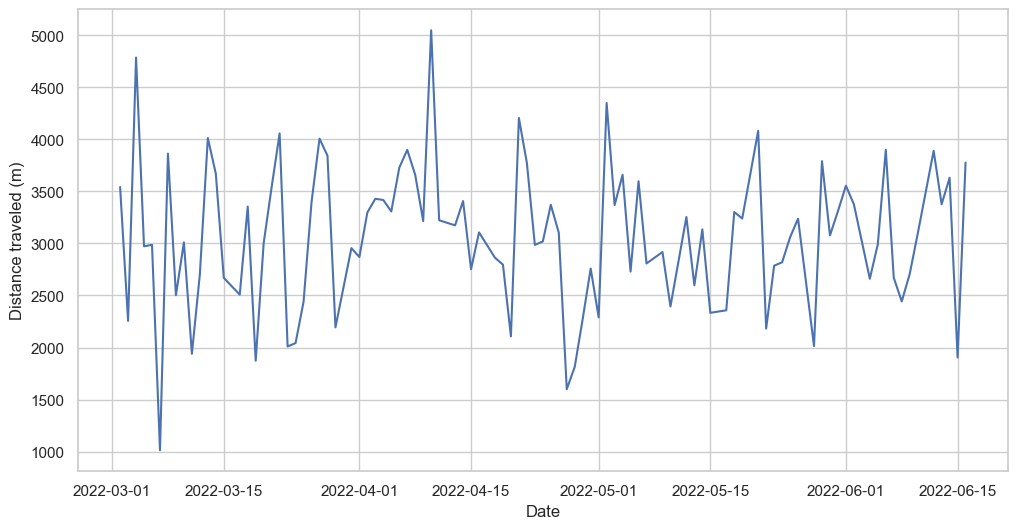

In [12]:
distance_df_daily = distance_df.assign(start_date = distance_df.get('start_date').apply(lambda x: x[:10]))
distance_df_daily = distance_df_daily.groupby('start_date').sum(numeric_only=True)

dates = pd.date_range(start_date,end_date)

energy = []

for d in dates:
    res = distance_df_daily[distance_df_daily.index == datetime.datetime.strftime(d,
    '%Y-%m-%d')]['distance']
    if len(res) == 0:
        energy.append(None)
    else:
        energy.append(res.iloc[0])

plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
sns.lineplot(x=dates, y=energy)
plt.ylabel('Distance traveled (m)')
plt.xlabel('Date')
plt.show()

# 6. Visualization

We've extracted lots of data, but what does it look like?

In this section, we will be visualizing our three kinds of data in a simple, customizable plot! This plot is intended to provide a starter example for plotting, whereas later examples emphasize deep control and aesthetics.

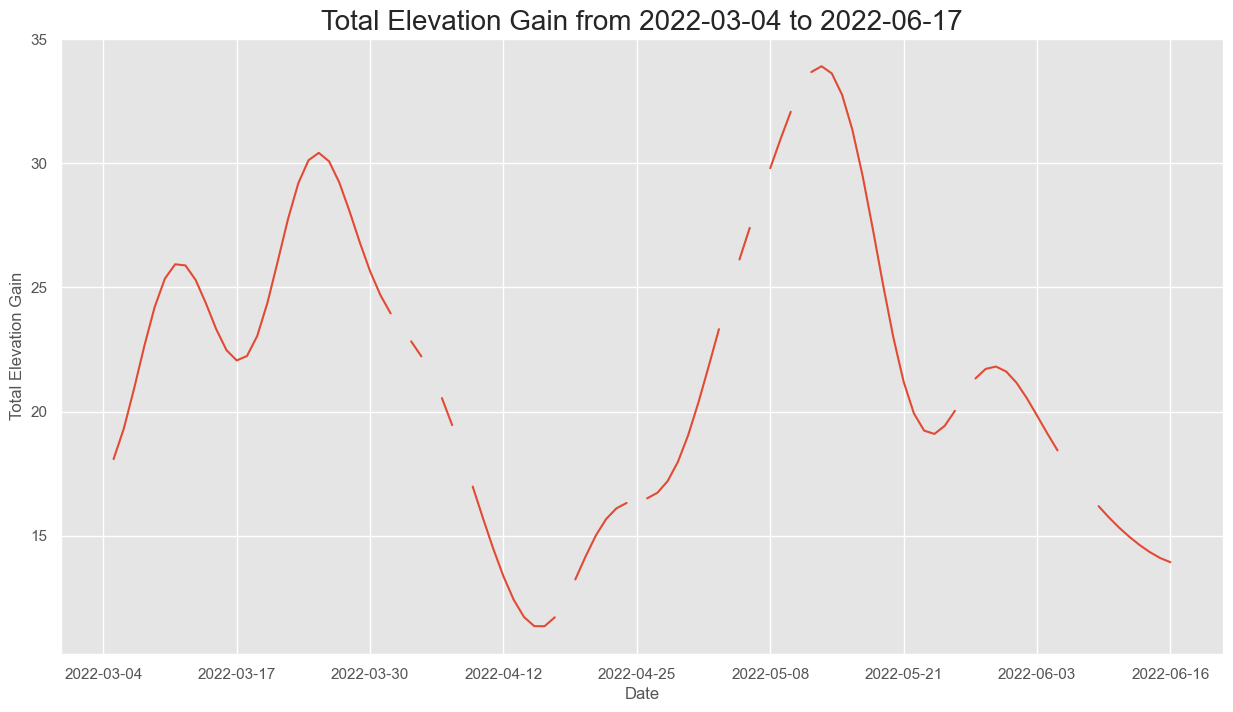

In [13]:
#@title Basic Plot
feature = "total_elevation_gain" #@param ['moving_time', 'elapsed_time','total_elevation_gain','average_speed']
start_date = "2022-03-04" #@param {type:"date"}
time_interval = "full time" #@param ["one week", "full time"]
smoothness = 0.02 #@param {type:"slider", min:0, max:1, step:0.01}
smooth_plot = True #@param {type:"boolean"}

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

start_date = datetime.strptime(start_date, '%Y-%m-%d')

if time_interval == "one week":
    day_idxes = [i for i,d in enumerate(dates) if d >= start_date and d <= start_date + timedelta(days=7)]
    end_date = start_date + timedelta(days=7)
elif time_interval == "full time":
    day_idxes = [i for i,d in enumerate(dates) if d >= start_date]
    end_date = dates[-1]

if feature == "moving_time":
    moving_time_daily = moving_time_df.assign(start_date = moving_time_df.get('start_date').apply(lambda x: x[:10]))
    moving_time_daily = moving_time_daily.groupby('start_date').sum(numeric_only=True)
    concat_moving_time = []
    for i,d in enumerate(dates):
        day = d.strftime('%Y-%m-%d')
        if i in day_idxes:
            mt = moving_time_daily[moving_time_daily.index==day]
            if len(mt) != 0:
                concat_moving_time += [(day,mt.iloc[0].moving_time)]
            else:
                concat_moving_time += [(day,None)]
    ts = [x[0] for x in concat_moving_time]

    day_arr = [x[1] for x in concat_moving_time]

    sigma = 200 * smoothness

    title_fillin = "Moving Time"

if feature == "elapsed_time":
    elapsed_time_daily = elapsed_time_df.assign(start_date = elapsed_time_df.get('start_date').apply(lambda x: x[:10]))
    elapsed_time_daily = elapsed_time_daily.groupby('start_date').sum(numeric_only=True)
    concat_elapsed_time = []
    for i,d in enumerate(dates):
        day = d.strftime('%Y-%m-%d')
        if i in day_idxes:
            et = elapsed_time_daily[elapsed_time_daily.index==day]
            if len(et) != 0:
                concat_elapsed_time += [(day,et.iloc[0].elapsed_time)]
            else:
                concat_elapsed_time += [(day,None)]
    ts = [x[0] for x in concat_elapsed_time]

    day_arr = [x[1] for x in concat_elapsed_time]

    sigma = 200 * smoothness

    title_fillin = "Elapsed Time"

if feature == "total_elevation_gain":
    total_elevation_gain_daily = total_elevation_gain_df.assign(start_date = total_elevation_gain_df.get('start_date').apply(lambda x: x[:10]))
    total_elevation_gain_daily = total_elevation_gain_daily.groupby('start_date').sum(numeric_only=True)
    concat_total_elevation_gain = []
    for i,d in enumerate(dates):
        day = d.strftime('%Y-%m-%d')
        if i in day_idxes:
            et = total_elevation_gain_daily[total_elevation_gain_daily.index==day]
            if len(et) != 0:
                concat_total_elevation_gain += [(day,et.iloc[0].total_elevation_gain)]
            else:
                concat_total_elevation_gain += [(day,None)]
    ts = [x[0] for x in concat_total_elevation_gain]

    day_arr = [x[1] for x in concat_total_elevation_gain]

    sigma = 200 * smoothness

    title_fillin = "Total Elevation Gain"

if feature == "average_speed":
    average_speed_daily = average_speed_df.assign(start_date = average_speed_df.get('start_date').apply(lambda x: x[:10]))
    average_speed_daily = average_speed_daily.groupby('start_date').sum(numeric_only=True)
    concat_average_speed = []
    for i,d in enumerate(dates):
        day = d.strftime('%Y-%m-%d')
        if i in day_idxes:
            et = average_speed_daily[average_speed_daily.index==day]
            if len(et) != 0:
                concat_average_speed += [(day,et.iloc[0].average_speed)]
            else:
                concat_average_speed += [(day,None)]
    ts = [x[0] for x in concat_average_speed]

    day_arr = [x[1] for x in concat_average_speed]

    sigma = 200 * smoothness

    title_fillin = "Average Speed"
    
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(15, 8))

    if smooth_plot:
        def to_numpy(day_arr):
            arr_nonone = [x for x in day_arr if x is not None]
            mean_val = int(np.mean(arr_nonone))
            for i,x in enumerate(day_arr):
                if x is None:
                    day_arr[i] = mean_val

            return np.array(day_arr)

        none_idxes = [i for i,x in enumerate(day_arr) if x is None]
        day_arr = to_numpy(day_arr)
        from scipy.ndimage import gaussian_filter
        day_arr = list(gaussian_filter(day_arr, sigma=sigma))
        for i, x in enumerate(day_arr):
            if i in none_idxes:
                day_arr[i] = None

    plt.plot(ts, day_arr)
    start_date_str = start_date.strftime('%Y-%m-%d')
    end_date_str = end_date.strftime('%Y-%m-%d')
    plt.title(f"{title_fillin} from {start_date_str} to {end_date_str}",
              fontsize=20)
    plt.xlabel("Date")
    plt.xticks(ts[::int(len(ts)/8)])
    plt.ylabel(title_fillin)
    plt.show()

This plot allows you to quickly scan your data at many different time scales (week and full) and for different kinds of measurements (heart rate and weight), which enables easy and fast data exploration.

Furthermore, the smoothness parameter makes it easy to look for patterns in long-term trends.

# 7. Advanced Visualization

Now we'll do some more advanced plotting that at times features hardcore matplotlib hacking with the benefit of aesthetic quality.

## 7.1 Visualizing participant's Overall Activity!

Whenever our participant is curious and logs into Strava to check their overall summary, the Strava app would present their data in the form of a barchart. It should look something similar to this: <br>
<img src="https://i.imgur.com/cr5VYpu.png" height="300">
 <br>
<i>Above is a plot from the app! </i><br> <br>

Now that we have user's data, let's try to recreate the chart above using our python skills!

In [14]:
elevation_df = total_elevation_gain_df.assign(total_elevation_gain 
  = total_elevation_gain_df['total_elevation_gain'].apply(lambda elevation: elevation*3.281))
elevation_df = elevation_df.merge(distance_df.get(['distance','start_date']),on='start_date')
elevation_df = elevation_df.merge(moving_time_df.get(['moving_time','start_date']),on='start_date')
elevation_df

,name,id,start_date,total_elevation_gain,distance,moving_time
0,Night Run,2139839185,2022-03-02T00:00:00Z,67.5886,3543.0,1307
1,Morning Run,7665000065,2022-03-03T00:00:00Z,154.8632,2255.8,1503
2,Post Lunch Run,8041480841,2022-03-06T00:00:00Z,0.0000,2987.2,1313
3,Morning Run,7482574811,2022-03-07T00:00:00Z,135.8334,1012.4,1537
4,Late Night Run,1689508992,2022-03-08T00:00:00Z,0.0000,3863.5,968
...,...,...,...,...,...,...
70,Late Night Run,1335671864,2022-06-10T00:00:00Z,0.0000,3093.1,937
71,Night Run,5625345745,2022-06-12T00:00:00Z,0.0000,3890.7,1168
72,Post Lunch Run,3008322504,2022-06-14T00:00:00Z,84.3217,3631.7,1235
73,Evening Run,5644714362,2022-06-15T00:00:00Z,23.2951,1903.5,1088


usage: mv [-f | -i | -n] [-hv] source target
       mv [-f | -i | -n] [-v] source ... directory


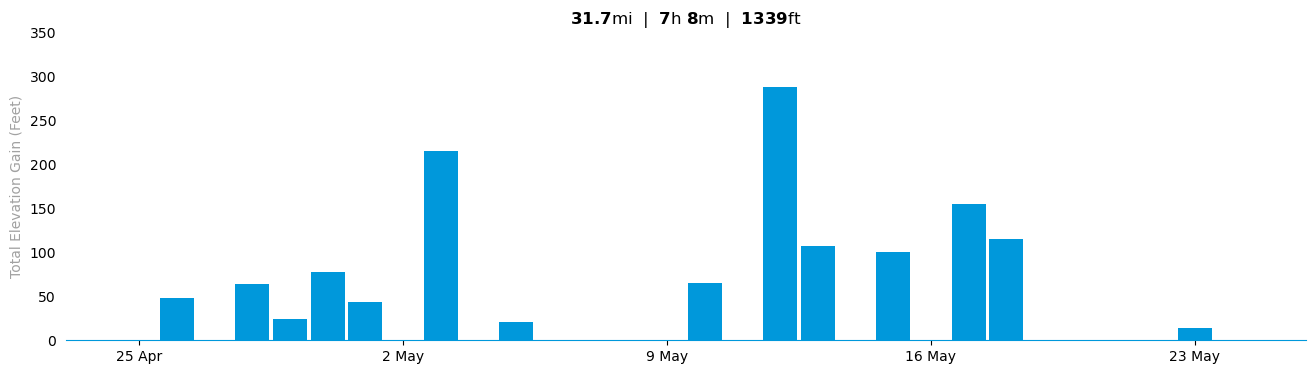

In [15]:
from datetime import datetime, timedelta, date
import seaborn as sns

#@title Set date range for the chart above

start = "2022-04-25" #@param {type:"date"}
end = "2022-05-25" #@param {type:"date"}

#Converting all the elevation gains from metres to feet
elevation_df = total_elevation_gain_df.assign(total_elevation_gain 
  = total_elevation_gain_df['total_elevation_gain'].apply(lambda elevation: elevation*3.281))
elevation_df = elevation_df.merge(distance_df.get(['distance','start_date']),on='start_date')
elevation_df = elevation_df.merge(moving_time_df.get(['moving_time','start_date']),on='start_date')

#Function that converts data into a date time object
datefixer = lambda date: datetime.fromisoformat(date[0:10])

#Applying datefixer function to every column of elevation_df
elevation_df = elevation_df.assign(date 
                          = elevation_df.get('start_date').apply(datefixer))

#Dictionary to store dates froms start to end date along with elevations
date_etime = {}

#Starting date of our chart
start_date = date(int(start.split('-')[0]),int(start.split('-')[1]),
                  int(start.split('-')[2]))

#Ending date of our chart
end_date = date(int(end.split('-')[0]),int(end.split('-')[1]),
                int(end.split('-')[2]))

#A list of all dates between start and end date
dates = list(pd.date_range(start_date,end_date-timedelta(days=1),freq='d'))

# Storing toal distance, time and elevation
total_distance = 0
total_time = 0
total_elevation = 0

#Loop to find the elevation for each date within the Data Frame
for date_val in dates:
  #Initializes the current date in the dictionary as zero
  date_etime[str(date_val.day)+" "+str(date_val.month_name())[:3]] = 0
  for actvity_index in range(len(elevation_df)):
    #Checks if the current date is in the activity DataFrame
      if(date_val == elevation_df.iloc[actvity_index].get('date')):
        #Storing total time, distance and elevation
        total_distance = (total_distance 
        + elevation_df.iloc[actvity_index].get('distance'))
        total_time = (total_time +
               elevation_df.iloc[actvity_index].get('moving_time'))
        total_elevation = (total_elevation +
               elevation_df.iloc[actvity_index].get('total_elevation_gain'))
        #Stores the elevation of current date in dictionary
        date_etime[(str(date_val.day)+" "+
                  str(date_val.month_name())[:3])] = (date_etime[
                  str(date_val.day)+" "+str(date_val.month_name())[:3]] +
                  elevation_df.iloc[actvity_index].get('total_elevation_gain'))
#Resetting seaborn to prevent interference with matplotlib plots
sns.reset_orig()


# custom font
# https://stackoverflow.com/questions/35668219/how-to-set-up-a-custom-font-with-custom-path-to-matplotlib-global-font
# download the font and unzip (quiet so it does not print)
!wget -q 'https://dl.dafont.com/dl/?f=mustica_pro'
!unzip -qo "index.html?f=mustica_pro"

try:
    # move to directory where fonts should be kept
    !mv -f MusticaPro-SemiBold.otf

    # build cache, redirect to /dev/null to suppress stdout output
    !fc-cache -f -v > /dev/null
except:
    pass
    
import matplotlib as mpl
import matplotlib.font_manager as fm

# try and except, just in case something fails we fallback onto the
# default font
try:
    fe = fm.FontEntry(
        #font name
        fname='MusticaPro-SemiBold',
        name='DejaVu Sans')
    fm.fontManager.ttflist.insert(0, fe) # or append is fine
    mpl.rcParams['font.family'] = fe.name # = 'your custom ttf font name'
except:
    pass

#Creating a matplotlib plot of size 16,4
plt1 = plt.figure(figsize=(16,4))
ax = plt1.gca()

#Plotting a bar chart with our data in the dictionary
plt.bar(date_etime.keys(),date_etime.values(),color="#0098DB", width=0.9)

#Adding the title to the chart
plt.title( "$\\bf{"+str(round(total_distance / 1609,1))+"}$mi  |  "+
          "$\\bf{"+str(round(total_time/3600))+"}$h "+"$\\bf{"+
          str(round(total_time%60))+"}$m  |  "
          +"$\\bf{"+str(round(total_elevation))+"}$ft")

#Only showing xticks for one day/week
ax.set_xticks(ax.get_xticks()[::7])

#Limiting the y-axis based on our reference chart
plt.ylim((0,350))
plt.ylabel("Total Elevation Gain (Feet)",color="#a1a1a1")

# Removing the spines on top, left and right
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.tick_params(left=False, bottom=True)

#Setting the bottom spine to be the same color as the reference chart
ax.spines['bottom'].set_color('#0098DB')
plt.show()

## 7.2 Visualizing participant's Weekly Summary!

If our participant is curious about a more detailed breakdown of their runs, Strava would show you their weekly summary using the following chart: <br>
<img src="https://trailingclosure.com/content/images/2020/12/IMG_6409.jpg" height="300">
 <br>
Again, Let's try to recreate it using the data we have fetched from the Strava API<br><br>
<b>Note:</b> Weekly summary includes all the runs, walks and rides walks recorded by the participant.

Enter the dates for the start and end dates for this chart below! 

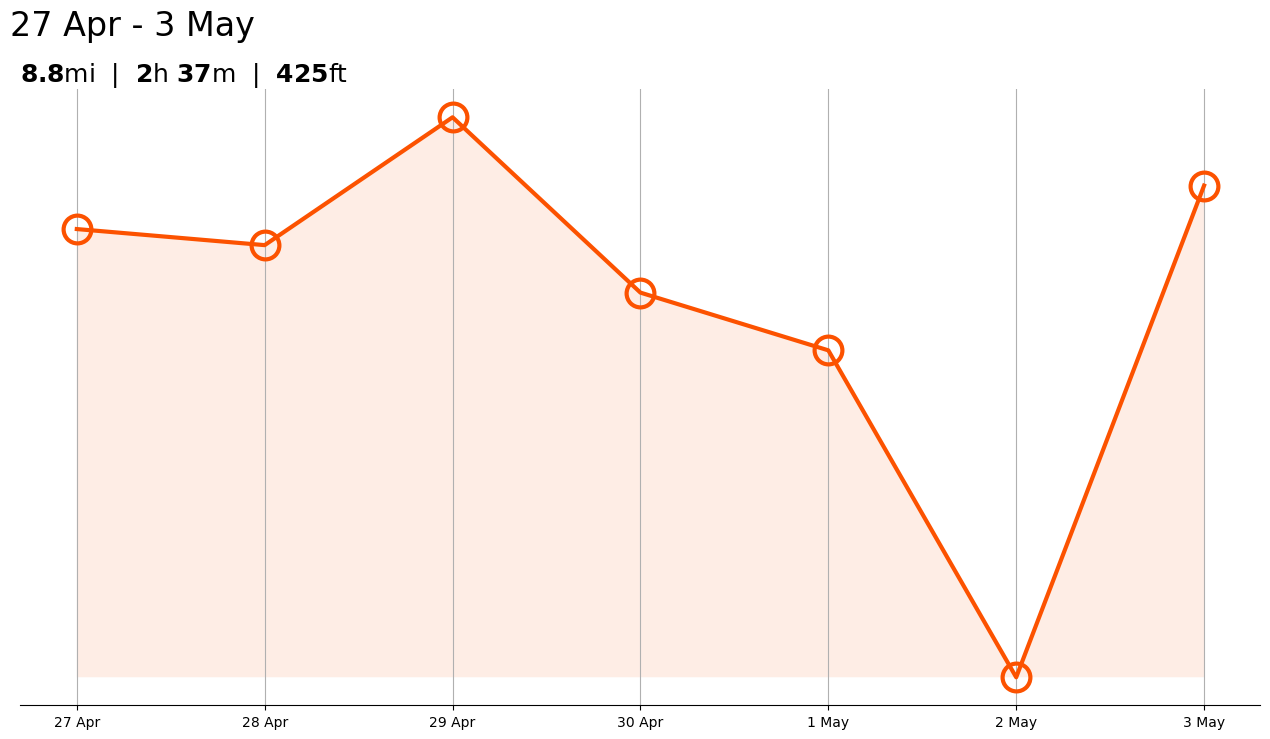

In [16]:
#@title Set date range for the chart above

start = "2022-04-27" #@param {type:"date"}
end = "2022-05-04" #@param {type:"date"}

#Function that converts data into a date time object
datefixer = lambda date: datetime.fromisoformat(date[0:10])

#Applying datefixer function to every column of df_strava_summary
df_strava_summary = elevation_df.assign(date 
                                =elevation_df.get('start_date').apply(datefixer))

#Dictionary to store the hourly frequency
date_etime = {}

#Starting date of our chart
start_date = date(int(start.split('-')[0]),
                  int(start.split('-')[1]),int(start.split('-')[2]))

#Ending date of our chart
end_date = date(int(end.split('-')[0]),
                int(end.split('-')[1]),int(end.split('-')[2]))

#Creating a list of dates between start and end date
dates = list(pd.date_range(start_date,end_date-timedelta(days=1),freq='d'))

# Storing toal distance, time and elevation
total_distance = 0
total_time = 0
total_elevation = 0

for date_val in dates:
  date_etime[str(date_val.day)+" "+str(date_val.month_name())[:3]] = 0
  for actvity_index in range(len(df_strava_summary)):
    #Checks if the current date is in the activity DataFrame
      if(date_val == df_strava_summary.iloc[actvity_index].get('date')):

        #Storing total time, distance and elevation

        total_distance = (total_distance +
                          df_strava_summary.iloc[actvity_index].get('distance'))
        
        total_time = (total_time +
                      df_strava_summary.iloc[actvity_index].get('moving_time'))
        
        total_elevation = (total_elevation +
              df_strava_summary.iloc[actvity_index].get('total_elevation_gain'))
        
        #Stores the elevation of moving time in dictionary
        date_etime[str(date_val.day)+" "
        +str(date_val.month_name())[:3]] = (date_etime[str(date_val.day)
        +" "+str(date_val.month_name())[:3]] +
         df_strava_summary.iloc[actvity_index].get('moving_time')/60)

#Resetting seaborn to prevent interference with matplotlib plots
sns.reset_orig()

# Creating a matplotlib plot of size 16,8
plt1 = plt.figure(figsize=(16,8))
ax = plt1.gca()


plt.plot(list(date_etime.keys()),list(date_etime.values()),color="#FC5200",
         marker='o', fillstyle='none', lw=3, markerfacecolor='white', ms=20, 
         mew=3, markeredgecolor='#FC5200')

plt.fill_between(list(date_etime.keys()),
                 list(date_etime.values()), facecolor='#FC5200',alpha=0.1)



# Adding veritcal grids
plt.grid(axis="x")

# Hiding the y-ticks
ax.axes.get_yaxis().set_visible(False)

#Adding the title to the chart
plt.suptitle(list(date_etime.keys())[0]+" - "+
             list(date_etime.keys())[-1],fontsize=24,x=0.195)
#Adding the subtitle to the chart
plt.title( "$\\bf{"+str(round(total_distance / 1609,1))+"}$mi  |  "+
          "$\\bf{"+str(round(total_time/3600))+"}$h "+"$\\bf{"+
          str(round(total_time%60))+"}$m  |  "+"$\\bf{"+
          str(round(total_elevation))+"}$ft",fontsize=18,loc='left')

# Removing the spines on top, left and right
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()

<i>Above is a plot we created ourselves!</i>

## 7.3 Visualizing Participant's Runs!

Strava's website and app allows the user to visualize the routes for all their activities recorded synced on the Strava application. It is a very interesting feature as it lets the participants view the exact route they took during their activity on an actual map.

<img src="https://blog.strava.com/wp-content/uploads/2020/03/03-Save-Sync-Share.png"> <br>


Let's try to recreate the plots using the participant's data! <br> <br>
Here's a reference to how our overall result will look like

<img src="https://cf.veloviewer.com/img/veloviewer-strava-segments-homepage.png" width=700>

Interestingly, Strava provides us with this route data in the form of polylines. In the df_strava dataframe we can see a column called summary_polyline for all the individual activities. We will be using this column for our plot! <br>

Polyline is a encoded format that store coordinate location and it has to be decoded before it can be used. If we have a closer look into it, it is a bunch of characters that make no sense to an average reader.

In [17]:
import polyline
import folium

#Dictionary to save the coordinates of the first ride
my_ride = map_summary_polyline_df.iloc[1].get(['map.summary_polyline']).apply(polyline.decode)['map.summary_polyline']

#Select one activity to find the centroid of the map.
centroid = [
    np.mean([coord[0] for coord in my_ride]), 
    np.mean([coord[1] for coord in my_ride])
  ]

#Creating a map 
m = folium.Map(location=centroid, zoom_start=13)

# Plot all rides on map
for i in range(len(map_summary_polyline_df.head())):
    if len(map_summary_polyline_df.iloc[i].get(['map.summary_polyline'])['map.summary_polyline']) == 0:
        continue

    # Polyline.decode is a function that helps us decode this polyline data to coordinates
    my_ride = map_summary_polyline_df.iloc[i].get(['map.summary_polyline']).apply(polyline.decode)['map.summary_polyline']
    # We plot the route on the map.
    folium.PolyLine(my_ride, color='red').add_to(m)
display(m)

# 8. Statistical Data Analysis

Now that we have found, the weekly summary for the participant's activity time, let's plot some graphs to see if there is a correlation between the various metrics of the participants data.

In order to focus on the just the runs, we will have to clean the dataframe and only keep activities of the type 'Run'.

In [18]:
strava_df = max_speed_df.merge(max_heartrate_df.get(['start_date','max_heartrate']),on='start_date')

def filterRuns(data):
    dataframe = []
    for i in range(len(data)):
        name = data.iloc[i].get('name')
        if 'run' in name.lower():
            dataframe.append(True)
        else:
            dataframe.append(False)
    return dataframe


strava_df = strava_df[filterRuns(strava_df)]
strava_df

,name,id,start_date,max_speed,max_heartrate
0,Morning Run,3652724277,2022-03-01T00:00:00Z,3.0,135.9
1,Night Run,2139839185,2022-03-02T00:00:00Z,5.0,169.3
2,Morning Run,7665000065,2022-03-03T00:00:00Z,6.0,171.0
3,Morning Run,7482574811,2022-03-07T00:00:00Z,5.0,119.3
4,Night Run,8017966663,2022-03-10T00:00:00Z,3.0,175.5
...,...,...,...,...,...
79,Night Run,5625345745,2022-06-12T00:00:00Z,3.0,142.1
80,Evening Run,9714466621,2022-06-13T00:00:00Z,5.0,159.7
81,Post Lunch Run,3008322504,2022-06-14T00:00:00Z,0.0,142.8
82,Evening Run,5644714362,2022-06-15T00:00:00Z,4.0,150.2


In [19]:
# We will drop the null values and only get the columns we need
df_runs_cleaned = strava_df.get(['max_speed','max_heartrate']).dropna()

As the strava api returns the max_speed values in meters/second and our above plots use miles, we will convert max speed to km/hour to maintain consistency.

In [20]:
df_runs_cleaned = df_runs_cleaned.assign(max_speed =
                    df_runs_cleaned.get('max_speed').apply(lambda x: x*3.6))

Let's plot the cleaned Data Frame below!

In [21]:
df_runs_cleaned

,max_speed,max_heartrate
0,10.8,135.9
1,18.0,169.3
2,21.6,171.0
3,18.0,119.3
4,10.8,175.5
...,...,...
79,10.8,142.1
80,18.0,159.7
81,0.0,142.8
82,14.4,150.2


Maybe the heart rate is correlated with how fast you run. Let's test if this hypothesis is true. We will do so by plotting a scatterplot between those two metrics and finding the correlation.

First, we will plot a chart to see if there is a visual correlation between a partcipant's max heart rate and their max speed.

In [22]:
# Setting Figure Size in Seaborn
sns.set(rc={'figure.figsize':(16,8)})

# Setting Seaborn plot style
sns.set_style("darkgrid")

#Plotting our data
plot = sns.regplot(data=df_runs_cleaned, x="max_speed", y="max_heartrate")

#Renaming x and y labels
plot.set_ylabel("Maximum Heart Rate (bpm)", fontsize = 16)
plot.set_xlabel("Maximum Speed (km/hr)", fontsize = 16)


Text(0.5, 0, 'Maximum Speed (km/hr)')

As we can see from the scatterplot above, our regression line hints that there might be a correlation between maximum speed and maximum heart rate. Let's compute $R^2$ just to see exactly how correlated.

We'll follow [this documentation](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.linregress.html) and perform a linear regression to obtain the coefficient of determination.

In [23]:
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(
    df_runs_cleaned.get('max_speed'), df_runs_cleaned.get('max_heartrate'))

print(f'Slope: {slope:.3g}')
print(f'Coefficient of determination: {r_value**2:.3g}')
print(f'p-value: {p_value:.3g}')

Slope: -0.483
Coefficient of determination: 0.0221
p-value: 0.177


As we can see that the p-value is slightly over 17% which means that there is not enough evidence to convincingly conclude that that there is a correlation between heart rate and speed. Let's try to locate the outliers in this data and find points that might be skewing our dataset and preventing us from gathering enough evidence to prove our correlation.

# 9. Outlier Detection and Data Cleaning

Before finding the individual outlier values, it would be interesting to see the summary of our max_speed and max_heartrate parameters. It will give us a clear idea of what values are typical and which values can be considered atypical based on the data that we recieved from Strava.

In [24]:
df_runs_cleaned_summary = df_runs_cleaned.describe().get(
    ['max_speed','max_heartrate'])
df_runs_cleaned_summary

,max_speed,max_heartrate
count,84.000000,84.000000
mean,12.342857,154.651190
std,5.568290,18.096924
min,0.000000,101.900000
25%,7.200000,141.625000
50%,10.800000,152.050000
75%,14.400000,165.250000
max,28.800000,201.800000


To locate the outliers we will be using a supervised as well as unsupervised algorithm called the Elliptic Envelope. In statistical studies, Elliptic Envelope created an imaginary elliptical area around a given dataset where values inside that imaginary area is considered to be normal data, and anything else is assumed to be outliers. It assumes that the given Data follows a gaussian distribution.

"The main idea is to define the shape of the data and anomalies are those observations that lie far outside the shape. First a robust estimate of covariance of data is fitted into an ellipse around the central mode. Then, the Mahalanobis distance that is obtained from this estimate is used to define the threshold for determining outliers or anomalies." [(S. Shriram and E. Sivasankar ,2019, pp. 221-225)](https://ieeexplore.ieee.org/document/9004325)

In [25]:
from sklearn.covariance import EllipticEnvelope

#create the model, set the contamination as 0.02
EE_model = EllipticEnvelope(contamination = 0.02)

#implement the model on the data
outliers = EE_model.fit_predict(df_runs_cleaned[["max_speed", "max_heartrate"]])

#extract the labels
df_runs_cleaned["outlier"] = outliers

#change the labels
# We use -1 to mark an outlier and +1 for an inliner
df_runs_cleaned["outlier"] = df_runs_cleaned["outlier"].apply(
    lambda x: str(-1) if x == -1 else str(1))

#extract the score
df_runs_cleaned["EE_scores"] = EE_model.score_samples(
    df_runs_cleaned[["max_speed", "max_heartrate"]])

#print the value counts for inlier and outliers
print(df_runs_cleaned["outlier"].value_counts())

1     82
-1     2
Name: outlier, dtype: int64


Below we will replot the df_runs_cleaned dataframe to see how the two new columns were applied to it!

In [26]:
df_runs_cleaned

,max_speed,max_heartrate,outlier,EE_scores
0,10.8,135.9,1,-1.473824
1,18.0,169.3,1,-4.769528
2,21.6,171.0,1,-9.373804
3,18.0,119.3,1,-4.568848
4,10.8,175.5,1,-2.002058
...,...,...,...,...
79,10.8,142.1,1,-0.664627
80,18.0,159.7,1,-3.060558
81,0.0,142.8,1,-9.875360
82,14.4,150.2,1,-0.371175


Now that we have labeled the outliers as -1, let's try to see which values of max heartrate and max speed are being considered as outliers by our Elliptic Envelope Algorithm.

In [27]:
outlier_df = df_runs_cleaned[df_runs_cleaned.get('outlier')=='-1'].get(
    ['max_heartrate','max_speed'])
outlier_df

,max_heartrate,max_speed
15,193.7,18.0
40,136.8,28.8


Using the dataframe above, we can highlight these outlier values in our original scatterplot in order to visually asses which pair/s of max speed and max heart rate values are not following the general trend seen in our scatterplot.

In [28]:
df_runs_cleaned.drop(outlier_df.index)

,max_speed,max_heartrate,outlier,EE_scores
0,10.8,135.9,1,-1.473824
1,18.0,169.3,1,-4.769528
2,21.6,171.0,1,-9.373804
3,18.0,119.3,1,-4.568848
4,10.8,175.5,1,-2.002058
...,...,...,...,...
79,10.8,142.1,1,-0.664627
80,18.0,159.7,1,-3.060558
81,0.0,142.8,1,-9.875360
82,14.4,150.2,1,-0.371175


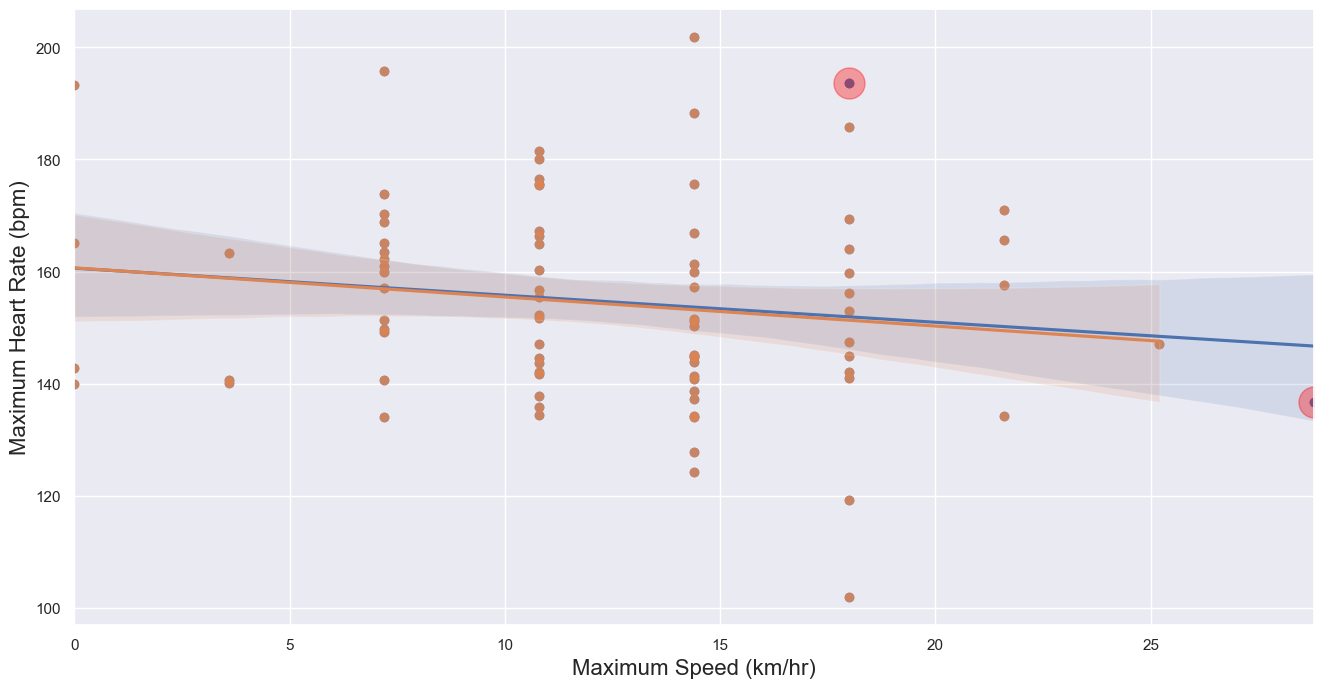

In [29]:
# Setting Figure Size in Seaborn
sns.set(rc={'figure.figsize':(16,8)})

# Setting Seaborn plot style
sns.set_style("darkgrid")

# Plotting our data
# We will calculate the regression line while not accounting for our outliers
plot = sns.regplot(data=df_runs_cleaned.drop(outlier_df.index), x="max_speed",
                   y="max_heartrate")

#Renaming x and y labels
plot.set_ylabel("Maximum Heart Rate (bpm)", fontsize = 16)
plot.set_xlabel("Maximum Speed (km/hr)", fontsize = 16)

# Plotting the outlier and highlighting it
plt.scatter(outlier_df.get('max_speed'),outlier_df.get('max_heartrate'))
plt.scatter(outlier_df.get('max_speed'),outlier_df.get('max_heartrate'),
            facecolors='red',alpha=.35, s=500)
plt.show()

Thus, the points highlighted in red are ones that seem to not be following the general trend of our dataset. Lastly, let's see what the new p-value is after outlier removal!

In [30]:
slope, intercept, r_value, p_value, std_err = stats.linregress(
    df_runs_cleaned.drop(outlier_df.index).get('max_speed'), 
    df_runs_cleaned.drop(outlier_df.index).get('max_heartrate'))

print(f'Slope: {slope:.3g}')
print(f'Coefficient of determination: {r_value**2:.3g}')
print(f'p-value: {p_value:.3g}')

Slope: -0.519
Coefficient of determination: 0.0241
p-value: 0.164
